### Binary Classification Modelling
-- Compliant / Non-compliant posts

In [1]:
import re
import pandas as pd
import numpy as np
import datetime
import time

import unicodedata
import emoji

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

#### Read the data from csv

In [2]:
# Download datafile from sharepoint
data_file_path = [INSERT]
data = pd.read_excel(data_file_path)
data_df = data[['name', 'content', 'breach', 'non_compliant']]

### Added features

In [3]:
def add_space_hashes(text_string):
    # Function to add a space behind the hash tags
    text_list = []
    
    # Convert any datetime text into string
    if isinstance(text_string, datetime.time) | isinstance(text_string, datetime.datetime) | isinstance(text_string, datetime.date):
        text_string = text_string.isoformat()

    for char in text_string:
        if char == '#':
            char = ' ' + char
        text_list.append(char)
        
    return ''.join(text_list)

In [4]:
def extract_hashtags(text_string):
 
    # initializing hashtag_list variable
    hashtag_list = []
 
    # splitting the text into words
    for word in text_string.split():
        # checking the first character of every word
        if word[0] == '#':
            # adding the word to the hashtag_list
            hashtag_list.append(word[1:])
        
    return hashtag_list

In [5]:
def extract_mentions(text_string):
    # Function to add a space behind mentions (@)
    result = re.findall("(^|[^@\w])@(\w{1,15})", text_string) # disregards emails
    # Add to a list
    result_list = ['@' + tuple(j for j in i if j)[-1] for i in result]
    
    return result_list

In [6]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.EMOJI_DATA)

def is_emoji(string): 
    """Returns True if the string is an emoji.""" 
    return string in unicode_codes.EMOJI_DATA 

In [7]:
def translate_emojis(text_string):
    result = []

    for char in text_string:
        if unicodedata.category(char) in ('So', 'Mn'):
            result.append(unicodedata.name(char))
        elif unicodedata.category(char) in ('Cs'):
            result.append('?') #char)
        else:
            result.append(char)

    return ','.join(result)

In [8]:
### Features addition ###

# Fill Nulls in content column
data_df['content'] = data_df['content'].fillna('')
# Apply spaces behind the hastags to identify hashes
data_df['content'] = data_df['content'].apply(lambda x: add_space_hashes(x))
# Extract all hashtags
data_df['hashtags'] = data_df['content'].apply(lambda x: extract_hashtags(x))
# Extract all mentiaons
data_df['mentions'] = data_df['content'].apply(lambda x: extract_mentions(x))
# Extract all emojis
data_df['emojis'] = data_df['content'].apply(lambda x: extract_emojis(x))
# Translate Emojis to text
data_df['emojis_text'] = data_df['emojis'].apply(lambda x: translate_emojis(x))

C:\Users\xtanl\AppData\Local\Temp\ipykernel_33056\4219806968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['content'] = data_df['content'].fillna('')
C:\Users\xtanl\AppData\Local\Temp\ipykernel_33056\4219806968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['content'] = data_df['content'].apply(lambda x: add_space_hashes(x))
C:\Users\xtanl\AppData\Local\Temp\ipykernel_33056\4219806968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [9]:
#data_df[data_df['emojis_text'].notnull()]

### Rule based Flagging

In [10]:
def contains_flagged_words(text_string):
    # Check if text contains flagged words
    flagged = ['financial advisor', 'advisor', 'financial adviser']
    for flag in flagged:
        if flag in text_string:
            return True
    return False

In [11]:
def contains_flagged_hashes(hash_list):
    # Check if hashtags contains flagged words
    flagged = ['financialadvisor', 'advisor', 'financialadviser']
    for flag in flagged:
        for hashtags in hash_list:
            if flag in hashtags:
                return True
    return False

In [12]:
# Check if there are words to be flagged - breach class
data_df['breach_flagwords'] = data_df['content'].apply(lambda x: contains_flagged_words(x))
# Check if there are words to be flagged in the hashes - breach class
data_df['breach_hashes'] = data_df['hashtags'].apply(lambda x: contains_flagged_hashes(x))

In [13]:
data_df.head(1)

,name,content,breach,non_compliant,hashtags,mentions,emojis,emojis_text,breach_flagwords,breach_hashes
0,Nicholas Goh Organisation,"Follow us at NGO’s BKK FastTrack 2022! In celebrating with the qualifiers, we had a lot of fun. Our team really bonded while traveling, eating, and shopping together! A true companion is one that travels together and stays together! It was 100% more enjoyable to spend time traveling together than going alone! Once again, congratulations to all the qualifiers!",No further action required,0,[],[],,,False,False


### Text preprocessing for model input

In [14]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
def text_cleaning(text):
    # remove tags
    text = re.sub("@\S+", "", text)
    # remove websites
    text = re.sub("https*\S+", "", text)
    # remove hashtags
    text = re.sub("#\S+", "", text)
    # remove apostrophes eg. abc's
    text = re.sub("\'\w+", "", text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), "", text)
    # remove numbers
    text = re.sub(r'\w*\d+\w*', "", text)
    # remove stopwords
    default_stopwords = stopwords.words('english')
    text = [word for word in text.split() if word not in default_stopwords]
    
    # remove spaces more than " "
    #text = re.sub('\s{2,}', " ", text)

    return text

In [16]:
# Clean text
data_df['cleaned_text'] = data_df.content.apply(lambda x: text_cleaning(x))

In [17]:
# Transform text to a count vector
countvectorizer = CountVectorizer(analyzer = text_cleaning, dtype = 'uint8').fit_transform(data_df['content']).toarray()

In [18]:
countvectorizer.shape

(99, 1111)

### Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# Does not take into account rule-based classification

posts = pd.DataFrame(countvectorizer)
X = countvectorizer
y = data_df['non_compliant']

In [21]:
X, y = X, y #[1:300]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.6, random_state=42)

### MLFlow setup

In [22]:
import mlflow
from mlflow.tracking import MlflowClient

from sklearn.metrics import auc, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay

In [23]:
# Interrupt the execution of this cell manually and go to http://127.0.0.1:5000
!mlflow ui

^C


In [24]:
EXPERIMENT_NAME = "ai_critic"
ARTIFACT_REPO = './ai_critic_mlflow'
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
client = MlflowClient() # Initialize client

# Get the experiment id if it already exists and if not create it
try:
    experiment_id = client.create_experiment(EXPERIMENT_NAME, artifact_location=ARTIFACT_REPO)
except:
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

### Binary Classification between Compliant / Non-compliant posts

#### Machine Learning (ML) models

In [25]:
def skmodel_experimentation(classifier, model_name, run_name):
    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name) as run:
        run_id = run.info.run_uuid
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "Testing baseline models for binary classification between compliant(0) and non-compliant (1) posts ")
        mlflow.sklearn.autolog() # Logged information like Parameters and Training metrics (like precission score, f1 score, ...)

        tags = {"Application": "Binary Classification - Non-Compliant/Compliant", # ML/DL/Sentiment/Topic
                "release_version": "1.0.0"}
        mlflow.set_tags(tags)

        clf = classifier
        clf.fit(X_train, y_train)

        valid_prediction = clf.predict_proba(X_valid)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_valid, valid_prediction)
        roc_auc = auc(fpr, tpr)
        mlflow.log_metrics({"validation_auc": roc_auc})
        
        ConfusionMatrixDisplay.from_estimator(clf, X_valid, y_valid,
                              #display_labels=['Non-compliant', 'Compliant'],
                              cmap='magma')
        plt.title('Confusion Matrix')
        plt.axis("off")
        filename = f'./{model_name}_validation_confusion_matrix.png'
        plt.savefig(filename)
        mlflow.log_artifact(filename)


2023/06/04 18:31:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\xtanl\miniconda3\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


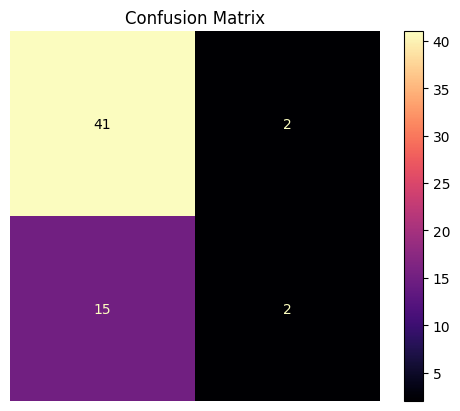

In [26]:
from sklearn.linear_model import LogisticRegression

# Baseline model
classifier = LogisticRegression()
model_name = 'LogReg'
run_name = 'LR_model'
skmodel_experimentation(classifier, model_name, run_name)

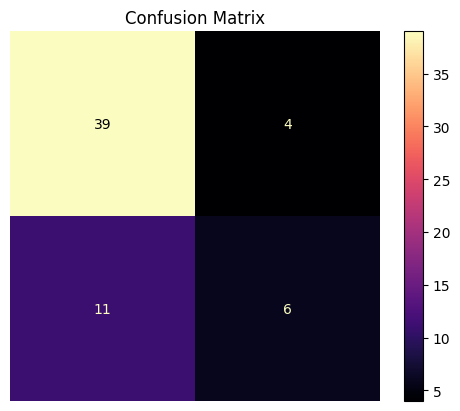

In [28]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
model_name = 'NB'
run_name = 'NaiveBayes_model'
skmodel_experimentation(classifier, model_name, run_name)

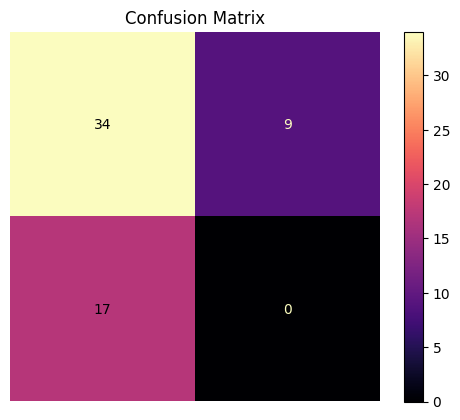

In [29]:
from sklearn.svm import SVC
classifier = SVC(probability=True)
model_name = 'SVC'
run_name = 'SVC_model'
skmodel_experimentation(classifier, model_name, run_name)

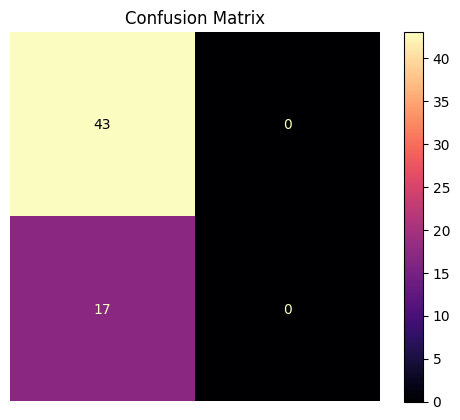

In [30]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier()
model_name = 'KNN'
run_name = 'KNN_model'
skmodel_experimentation(classifier, model_name, run_name)

#### Deep Learning (DL) models -- without training

In [31]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

import torch
from datasets import load_metric

C:\Users\xtanl\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# Define dataset here -- train/test
full_dataset = data_df[['content', 'non_compliant']]

In [33]:
# Choice of metrics
metric = load_metric("accuracy")

def compute_metrics(logits, labels):
    #predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=logits, references=labels)

C:\Users\xtanl\AppData\Local\Temp\ipykernel_33056\2201987639.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [34]:
def hfmodel_experimentation(model_name, dataset):
    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name) as run:
        run_id = run.info.run_uuid
        MlflowClient().set_tag(run_id,
                               "mlflow.note.content",
                               "Testing baseline models for binary classification between compliant(0) and non-compliant (1) posts")
        mlflow.sklearn.autolog() # Logged information like Parameters and Training metrics (like precission score, f1 score, ...)

        tags = {"Application": "Binary Classification - Non-Compliant/Compliant", # ML/DL/Sentiment/Topic
                "release_version": "1.0.0"}
        mlflow.set_tags(tags)
        
        # Add ID to binary labels
        id2label = {0: "compliant", 1: "non_compliant"}
        label2id = {"compliant": 0, "non_compliant": 1}

        # Initialise Tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        # Initialise the model
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=2, id2label=id2label, label2id=label2id
        )
        
        # Initialise prediction list
        predicted = []

        for text_string in dataset['content']:    
            inputs = tokenizer(text_string, return_tensors="pt")
            with torch.no_grad():
                logit = model(**inputs).logits
                #logits.append(logit)

            predicted_class_id = logit.argmax().item()
            #pred = model.config.id2label[predicted_class_id] #compliant / non_compliant
            predicted.append(predicted_class_id)

        labels = dataset['non_compliant']
        accuracy = compute_metrics(predicted, labels)
        mlflow.log_metrics({"training_accuracy_score": accuracy['accuracy']})

In [35]:
# Baseline model
model_name = "bert-base-cased"
hfmodel_experimentation(model_name, full_dataset)

C:\Users\xtanl\miniconda3\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\xtanl\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.d

In [36]:
model_name = "distilbert-base-cased"
hfmodel_experimentation(model_name, full_dataset)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.b